In [1]:
import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '~/CH/CH-cross/Fig3/Scenicplus/macaca/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '~/CH/tmp/'

In [2]:
## read in sparse matrix, with features & barcodes respectively.
from scipy.io import mmread, mmwrite, mminfo
coo_mtx_path = '~/CH/CH-cross/Fig3/Scenicplus/macaca/matrix.mtx'
coo_mtx = mmread(coo_mtx_path)
mtx = coo_mtx.tocsr()


features = pd.read_csv('~/CH/CH-cross/Fig3/Scenicplus/macaca/features.csv', sep = ',', names = ['features'], dtype = 'str')
barcodes = pd.read_csv('~/CH/CH-cross/Fig3/Scenicplus/macaca/barcodes.csv', sep = ',', names = ['barcode'], dtype = 'str')

from pycisTopic.cistopic_class import *
cistopic_obj = create_cistopic_object(fragment_matrix = mtx, cell_names = barcodes['barcode'], region_names = features['features'])


## Adding cell information
cell_data = pd.read_csv('~/CH/CH-cross/Fig3/Scenicplus/macaca/metadata.csv', sep = ',', dtype= 'str')

cell_data.index = cistopic_obj.cell_data.index
cistopic_obj.add_cell_data(cell_data)

2023-04-08 22:45:27,459 cisTopic     INFO     Creating CistopicObject
2023-04-08 22:45:32,755 cisTopic     INFO     Done!


In [2]:
import ray
ray.init('auto')

2023-04-11 01:57:22,821	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.153.239:6379...
2023-04-11 01:57:22,861	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [4]:
def run_cgs_models(
    cistopic_obj: "cisTopicObject",
    n_topics: List[int],
    n_cpu: Optional[int] = 1,
    n_iter: Optional[int] = 150,
    random_state: Optional[int] = 555,
    alpha: Optional[float] = 50,
    alpha_by_topic: Optional[bool] = True,
    eta: Optional[float] = 0.1,
    eta_by_topic: Optional[bool] = False,
    top_topics_coh: Optional[int] = 5,
    save_path: Optional[str] = None,
    **kwargs,
):
    """
    Run Latent Dirichlet Allocation using Gibbs Sampling as described in Griffiths and Steyvers, 2004.

    Parameters
    ----------
    cistopic_obj: cisTopicObject
        A :class:`cisTopicObject`. Note that cells/regions have to be filtered before running any LDA model.
    n_topics: list of int
        A list containing the number of topics to use in each model.
    n_cpu: int, optional
        Number of cpus to use for modelling. In this function parallelization is done per model, that is, one model will run entirely in a unique cpu. We recommend to set the number of cpus as the number of models that will be inferred, so all models start at the same time.
    n_iter: int, optional
        Number of iterations for which the Gibbs sampler will be run. Default: 150.
    random_state: int, optional
        Random seed to initialize the models. Default: 555.
    alpha: float, optional
        Scalar value indicating the symmetric Dirichlet hyperparameter for topic proportions. Default: 50.
    alpha_by_topic: bool, optional
        Boolean indicating whether the scalar given in alpha has to be divided by the number of topics. Default: True
    eta: float, optional
        Scalar value indicating the symmetric Dirichlet hyperparameter for topic multinomials. Default: 0.1.
    eta_by_topic: bool, optional
        Boolean indicating whether the scalar given in beta has to be divided by the number of topics. Default: False
    top_topics_coh: int, optional
        Number of topics to use to calculate the model coherence. For each model, the coherence will be calculated as the average of the top coherence values. Default: 5.
    save_path: str, optional
        Path to save models as independent files as they are completed. This is recommended for large data sets. Default: None.

    Return
    ------
    list of :class:`CistopicLDAModel`
        A list with cisTopic LDA models.

    References
    ----------
    Griffiths, T. L., & Steyvers, M. (2004). Finding scientific topics. Proceedings of the National academy of Sciences, 101(suppl 1), 5228-5235.
    """

    binary_matrix = sparse.csr_matrix(
        cistopic_obj.binary_matrix.transpose(), dtype=np.integer
    )
    region_names = cistopic_obj.region_names
    cell_names = cistopic_obj.cell_names
    #ray.init(num_cpus=n_cpu, **kwargs)
    model_list = ray.get(
        [
            run_cgs_model.remote(
                binary_matrix,
                n_topics=n_topic,
                cell_names=cell_names,
                region_names=region_names,
                n_iter=n_iter,
                random_state=random_state,
                alpha=alpha,
                alpha_by_topic=alpha_by_topic,
                eta=eta,
                eta_by_topic=eta_by_topic,
                top_topics_coh=top_topics_coh,
                save_path=save_path,
            )
            for n_topic in n_topics
        ]
    )
    #ray.shutdown()
    return model_list

In [5]:
models = run_cgs_models(cistopic_obj, 
                       n_topics = [20,30,40],
                       n_cpu = 20,
                       n_iter = 200,
                       random_state = 555,
                       alpha = 50,
                       alpha_by_topic = True,
                       eta = 0.1,
                       eta_by_topic = False,
                       save_path = None,
                       _temp_dir = tmpDir,ignore_reinit_error=True)

(run_cgs_model pid=31949) 2023-04-08 22:45:37,877 cisTopic     INFO     Running model with 20 topics
(run_cgs_model pid=31948) 2023-04-08 22:45:37,872 cisTopic     INFO     Running model with 40 topics
(run_cgs_model pid=32058) 2023-04-08 22:45:38,039 cisTopic     INFO     Running model with 30 topics
(run_cgs_model pid=31949) 2023-04-09 01:01:44,571 cisTopic     INFO     Model with 20 topics done!
(run_cgs_model pid=32058) 2023-04-09 02:09:57,783 cisTopic     INFO     Model with 30 topics done!
(run_cgs_model pid=31948) 2023-04-09 03:28:26,200 cisTopic     INFO     Model with 40 topics done!


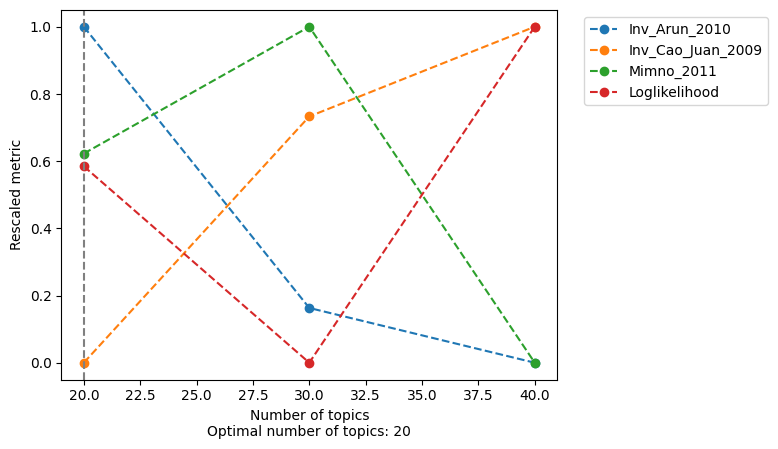

In [6]:
import pickle
with open(outDir + 'CGS_models.pkl',  'wb') as f:
    pickle.dump(models, f)
    
from pycisTopic.lda_models import *    
model = evaluate_models(models, select_model = None, return_model = True, metrics = ['Arun_2010', 'Cao_Juan_2009', 'Minmo_2011', 'loglikelihood'], plot_metrics = False, save = outDir + 'model_selection.pdf')


cistopic_obj.add_LDA_model(model)
with open(outDir + 'macaca_cistopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)
    
#import pickle
#infile = open(outDir + 'macaca_cistopicObject.pkl', 'rb')
#cistopic_obj = pickle.load(infile)
#infile.close()

2023-04-09 03:29:02,069 cisTopic     INFO     Finding neighbours
2023-04-09 03:29:05,938 cisTopic     INFO     Running UMAP


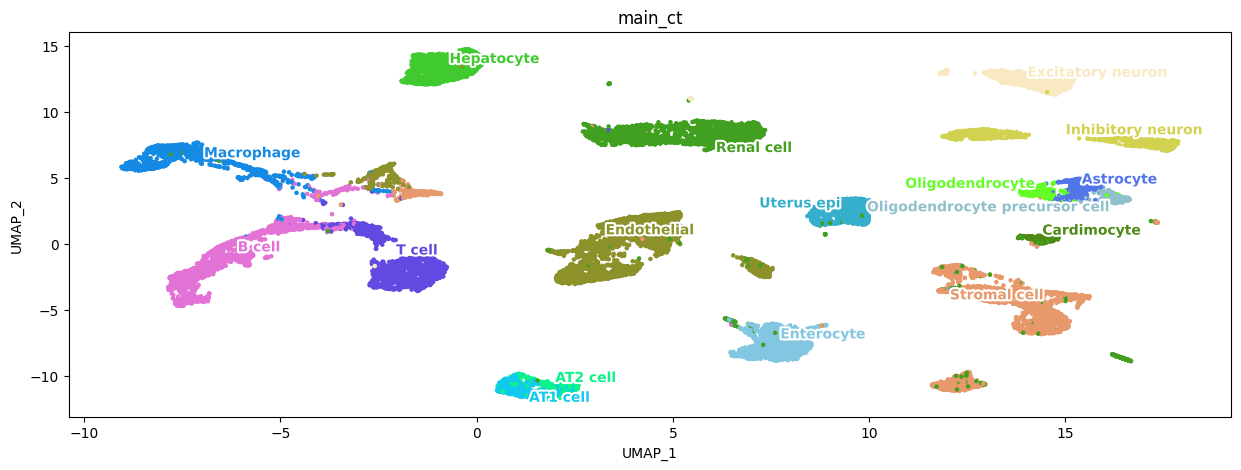

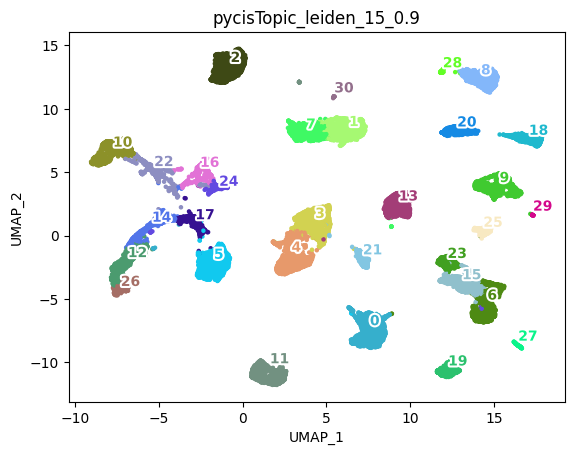

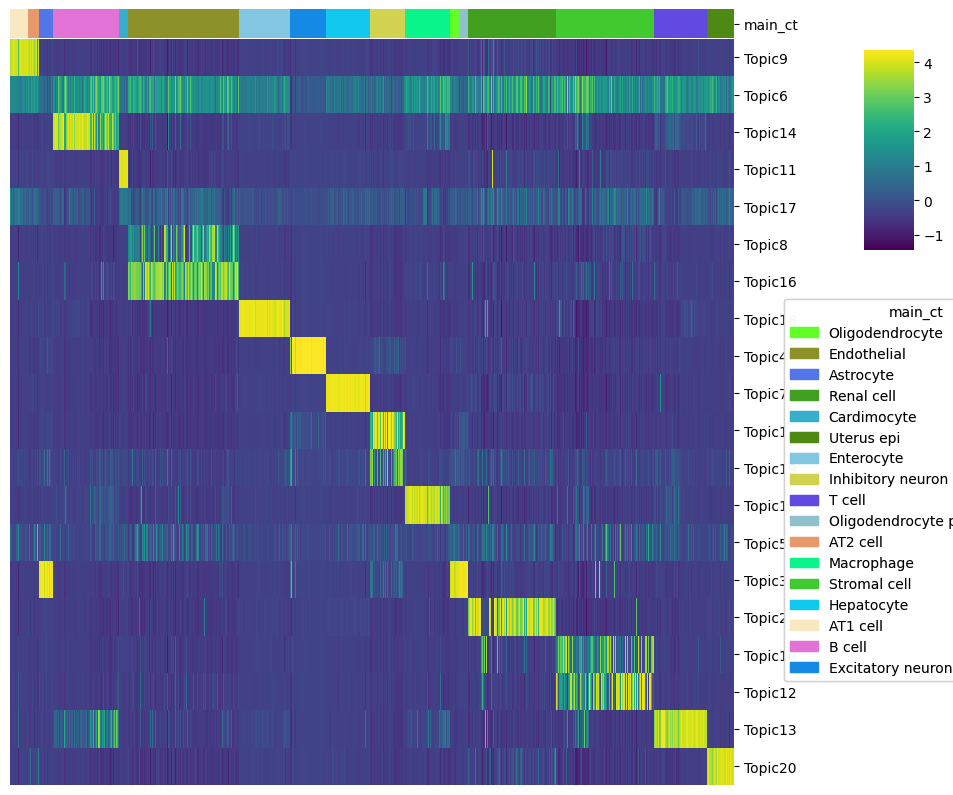

In [7]:
from pycisTopic.clust_vis import *
find_clusters(cistopic_obj, 
             target = 'cell',
             k = 15,
             res = [0.3, 0.5, 0.7, 0.9],
             prefix = 'pycisTopic_',
             scale = True,
             split_pattern = '-')
             
run_umap(cistopic_obj, target = 'cell', scale = True)

visual_path = outDir + '/visualization'
if not os.path.exists(visual_path):
    os.mkdir(visual_path)
plot_metadata(cistopic_obj, 
             reduction_name = 'UMAP',
             variables = ['main_ct','pycisTopic_leiden_15_0.9'], 
             target = 'cell',  num_columns = 1,
             text_size = 10, dot_size = 5,
             figsize = (15,5),
             save = outDir + '/visualization/dimensionality_reduction_label.pdf')

cell_topic_heatmap(cistopic_obj, 
                  variables = ['main_ct'], 
                  scale = True, 
                  legend_loc_x = 1.05, 
                  legend_loc_y = -1.2, 
                  legend_dist_y = -1,
                  figsize = (10, 10), 
                  save = outDir + 'visualization/heatmap_topic_contr.pdf')
                  
with open(outDir + 'macaca_cluster_cistopicObject.pkl', 'wb') as f:
    pickle.dump(cistopic_obj, f)

In [3]:
from pycisTopic.cistopic_class import *
from pycisTopic.lda_models import *  
from pycisTopic.clust_vis import *

import pickle
infile = open(outDir + 'macaca_cluster_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

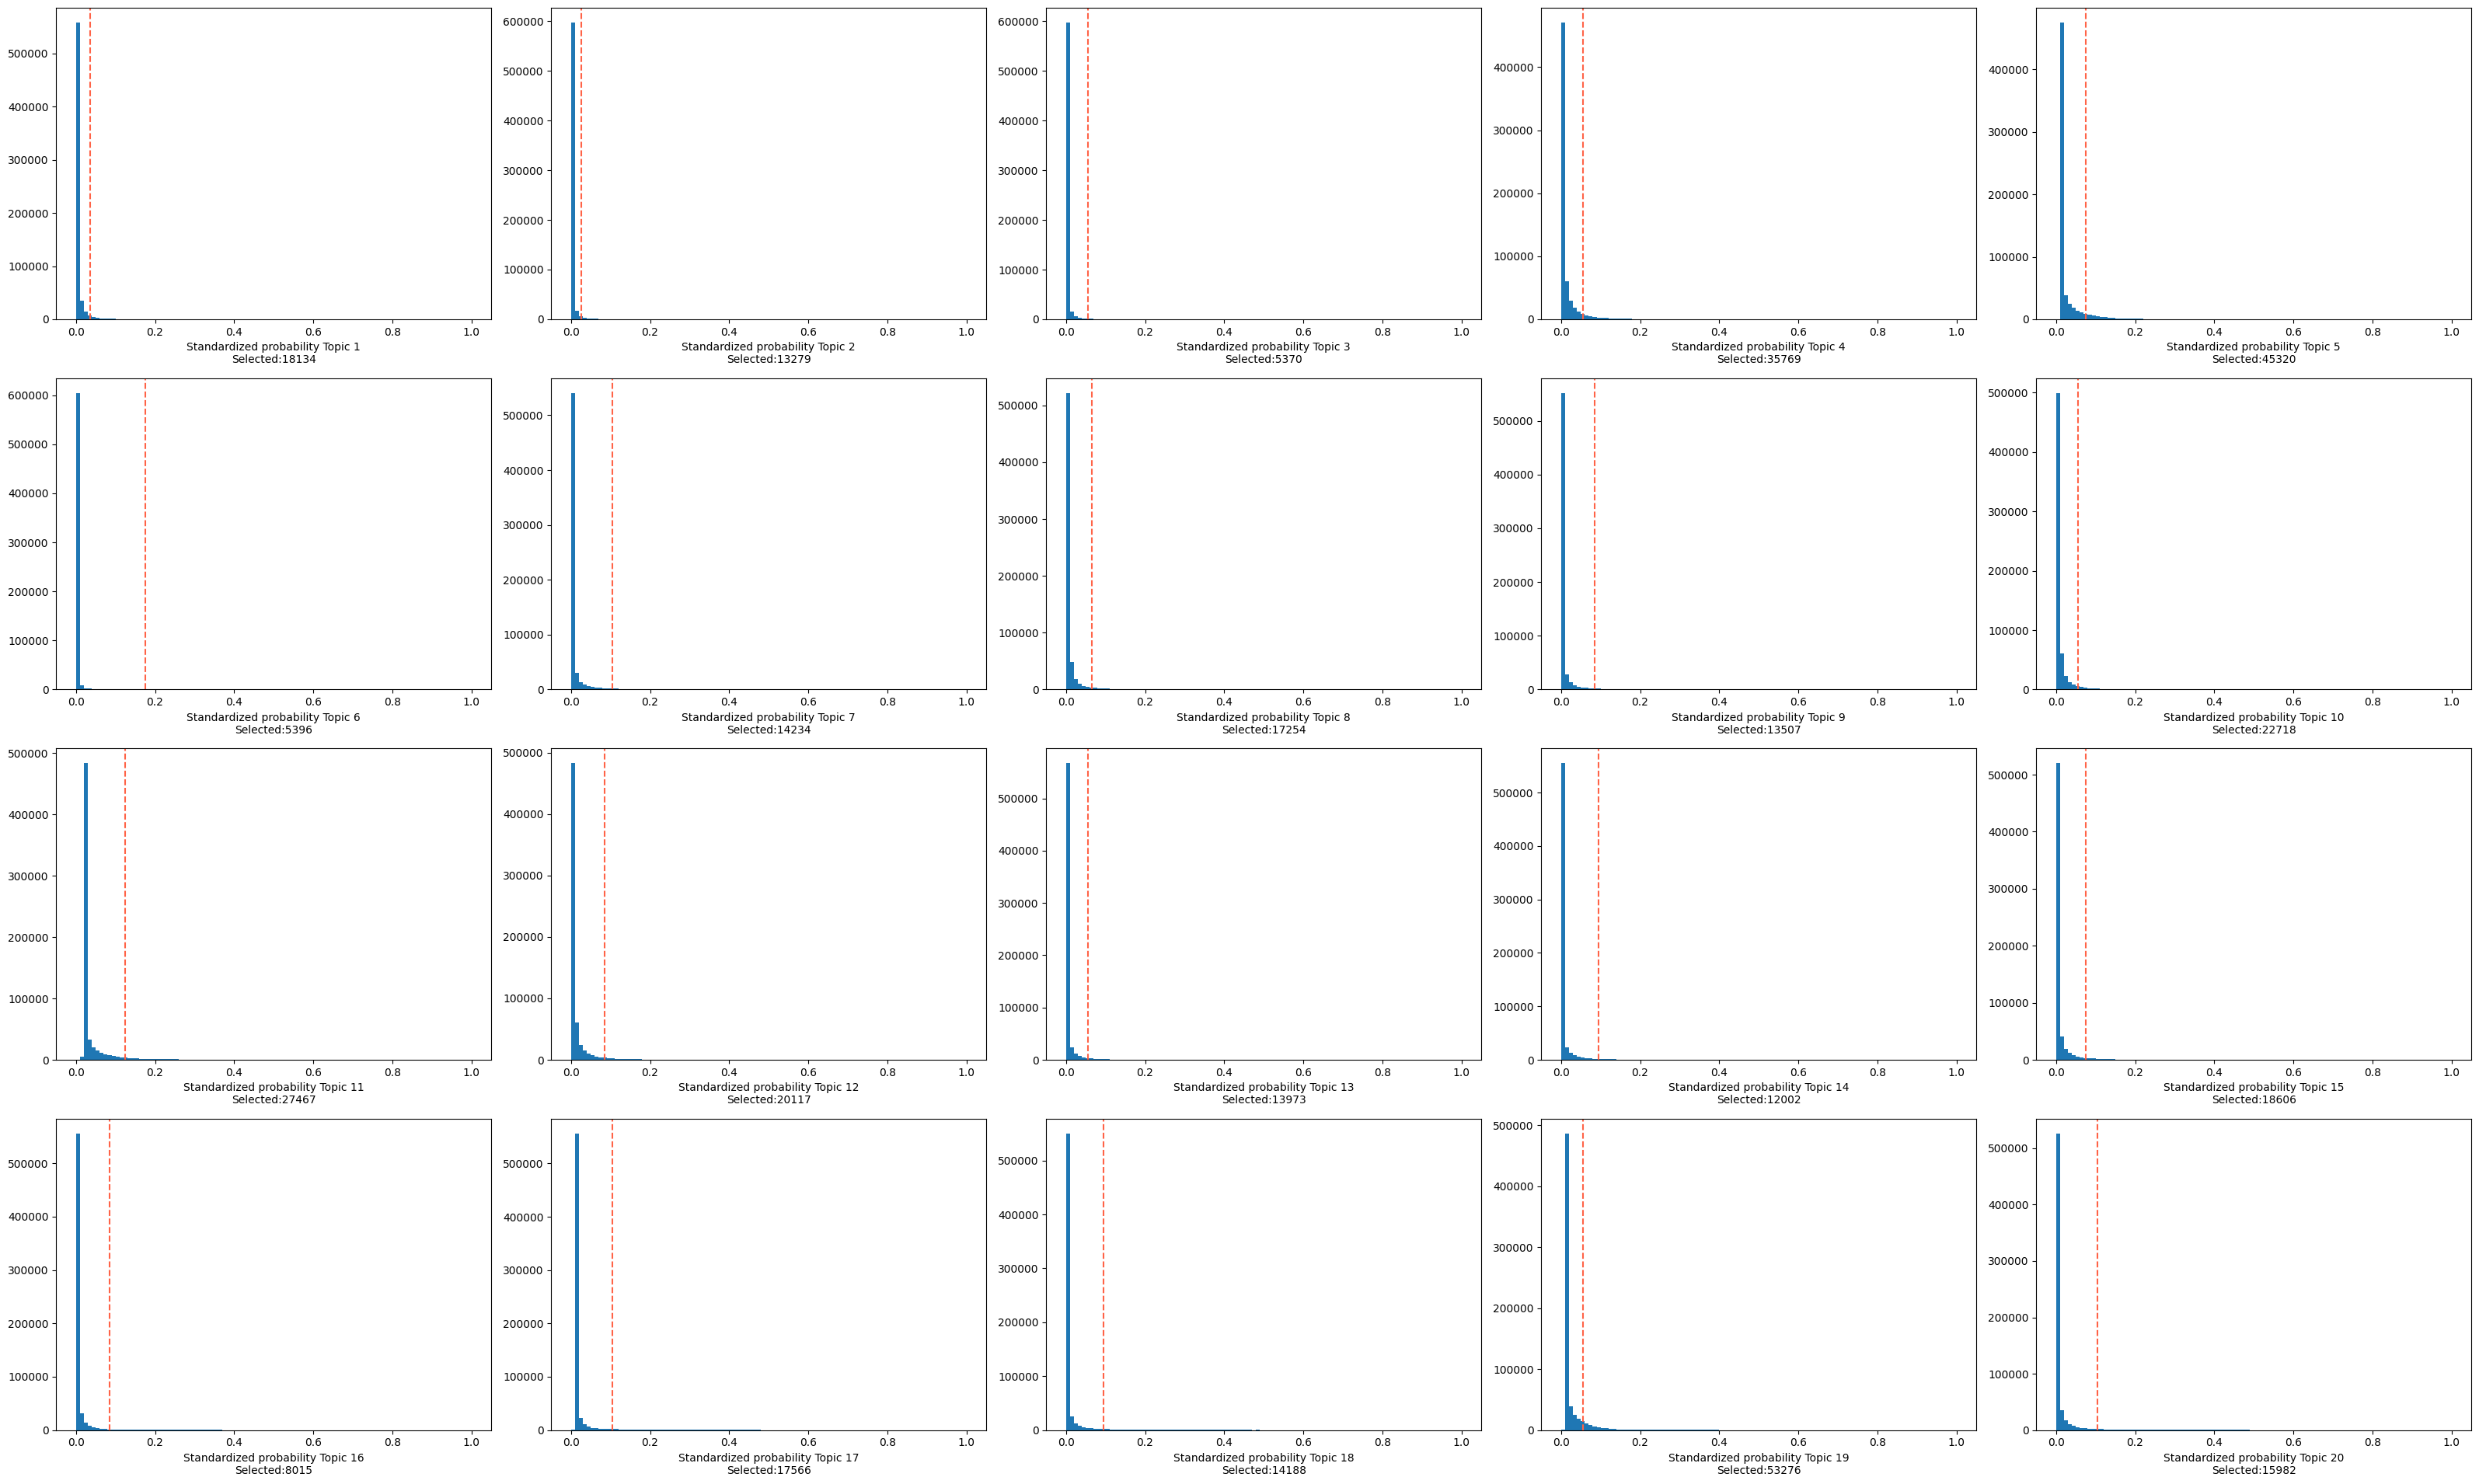

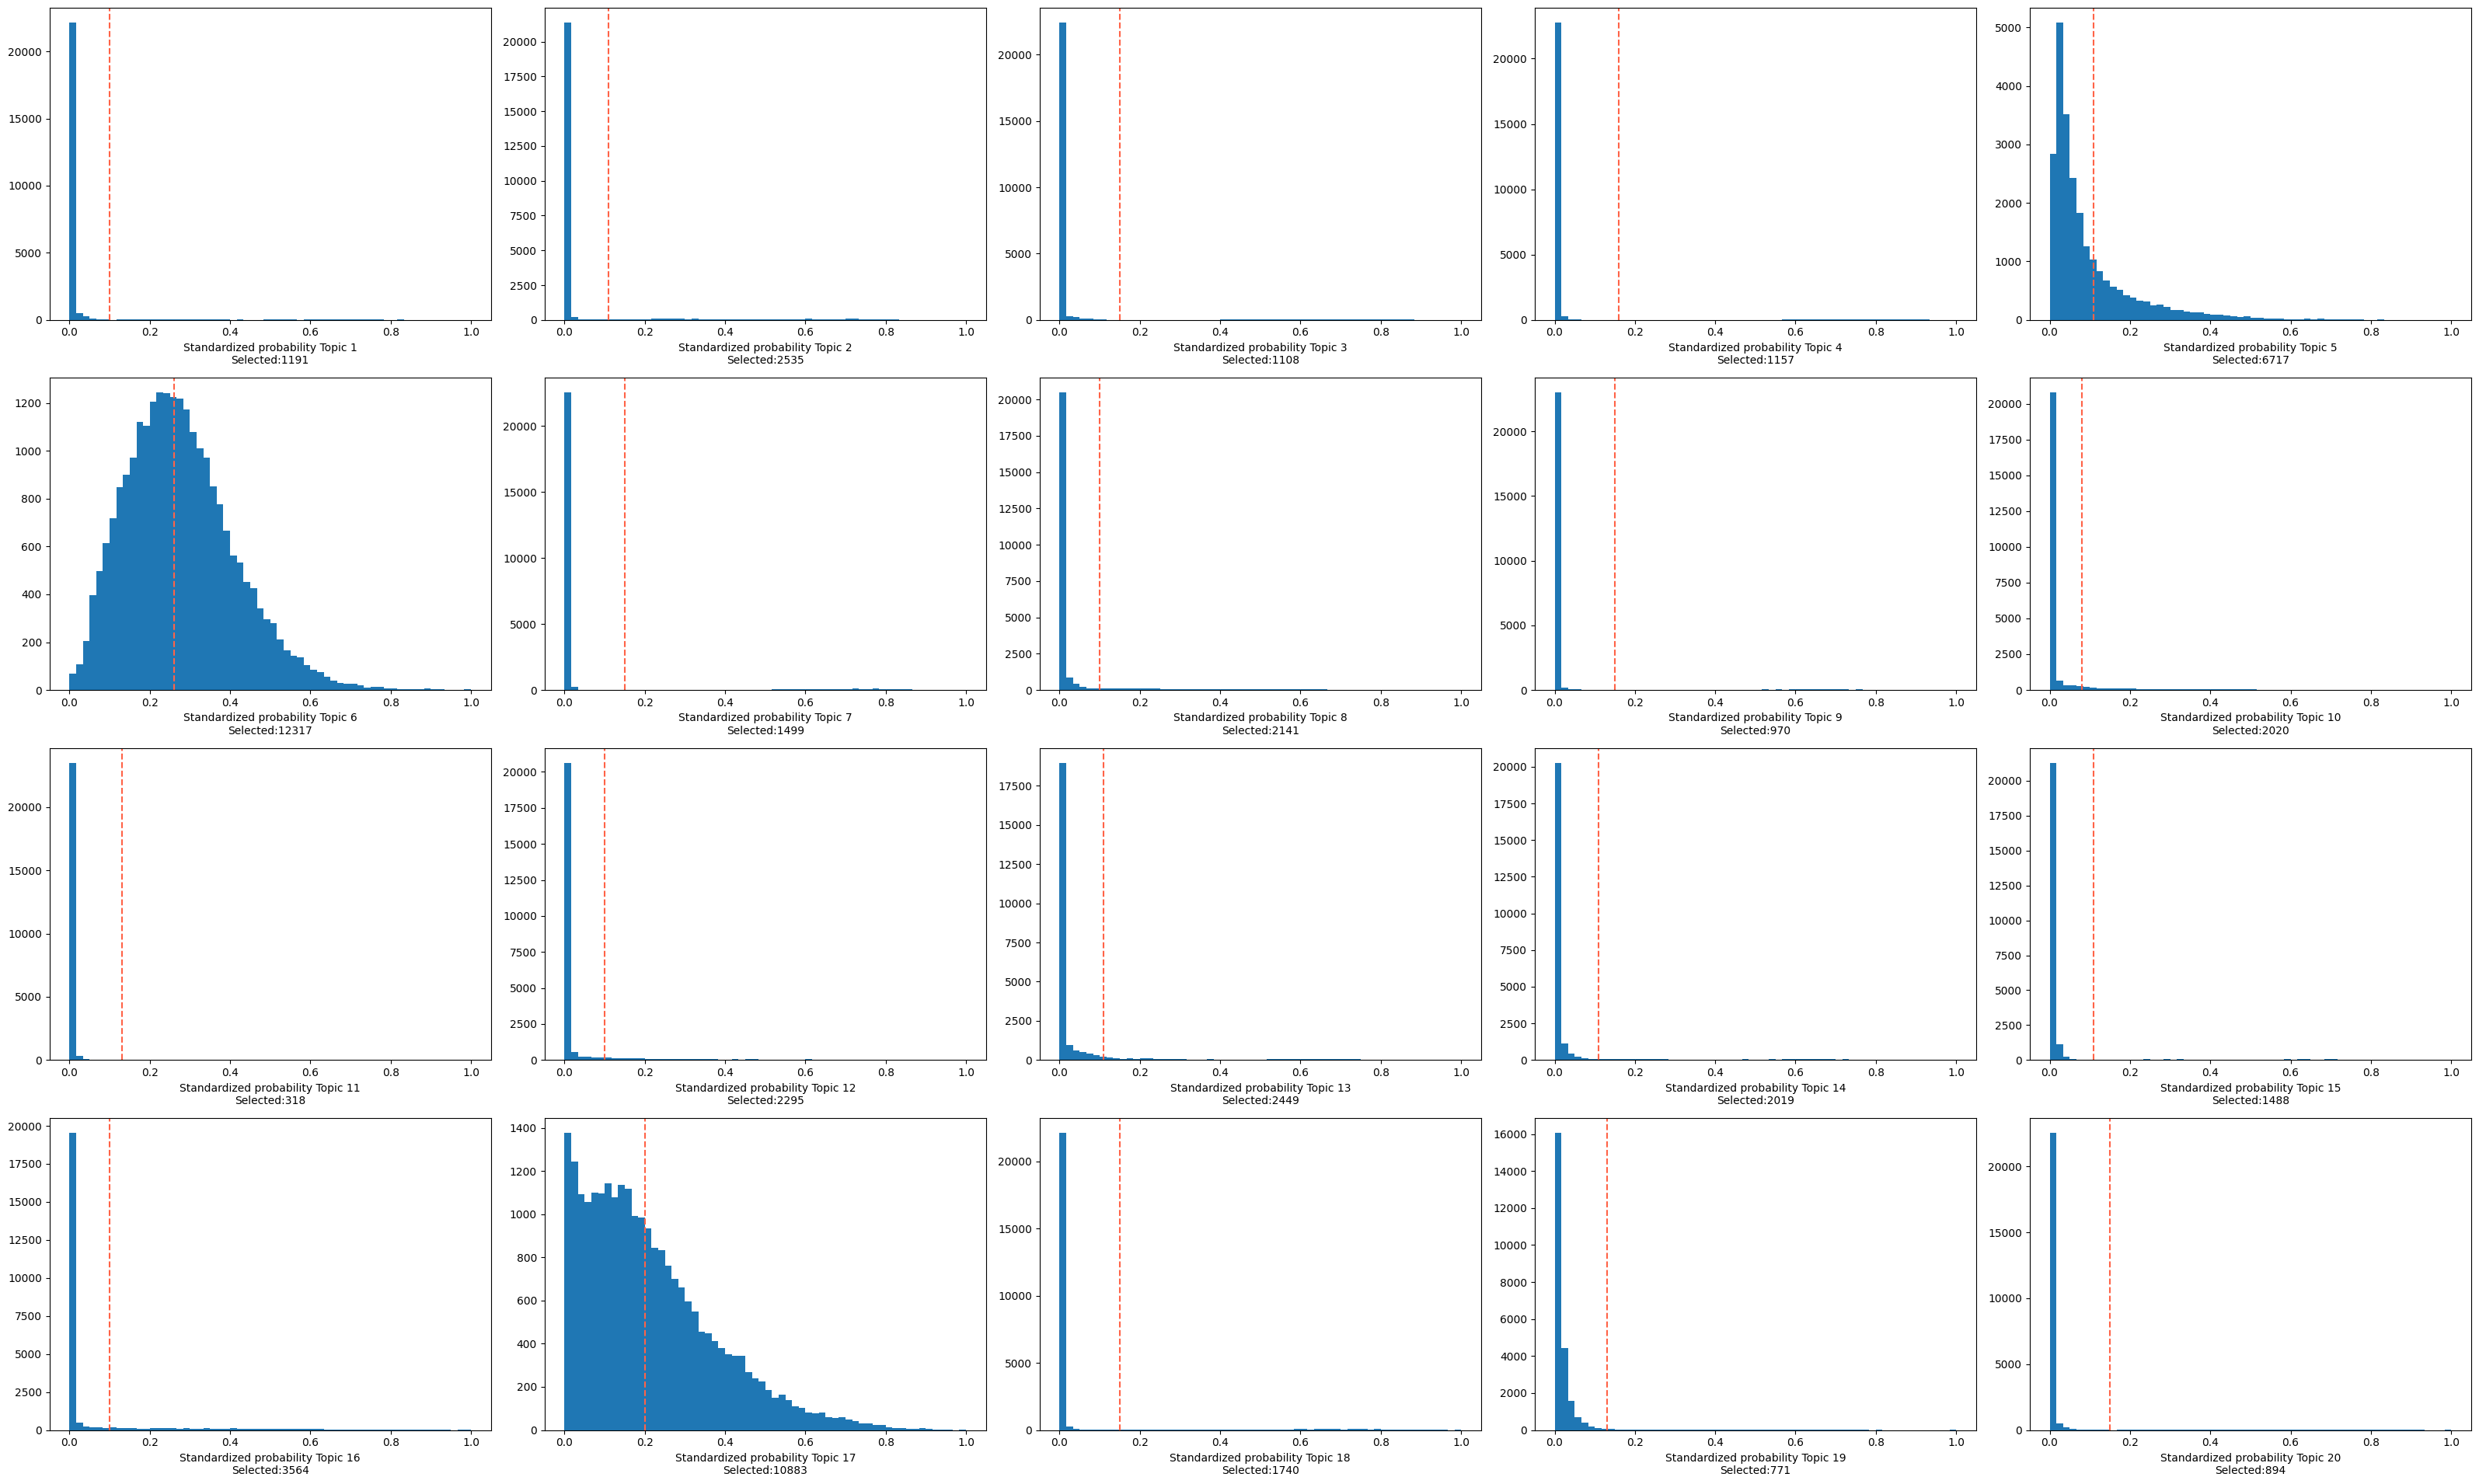

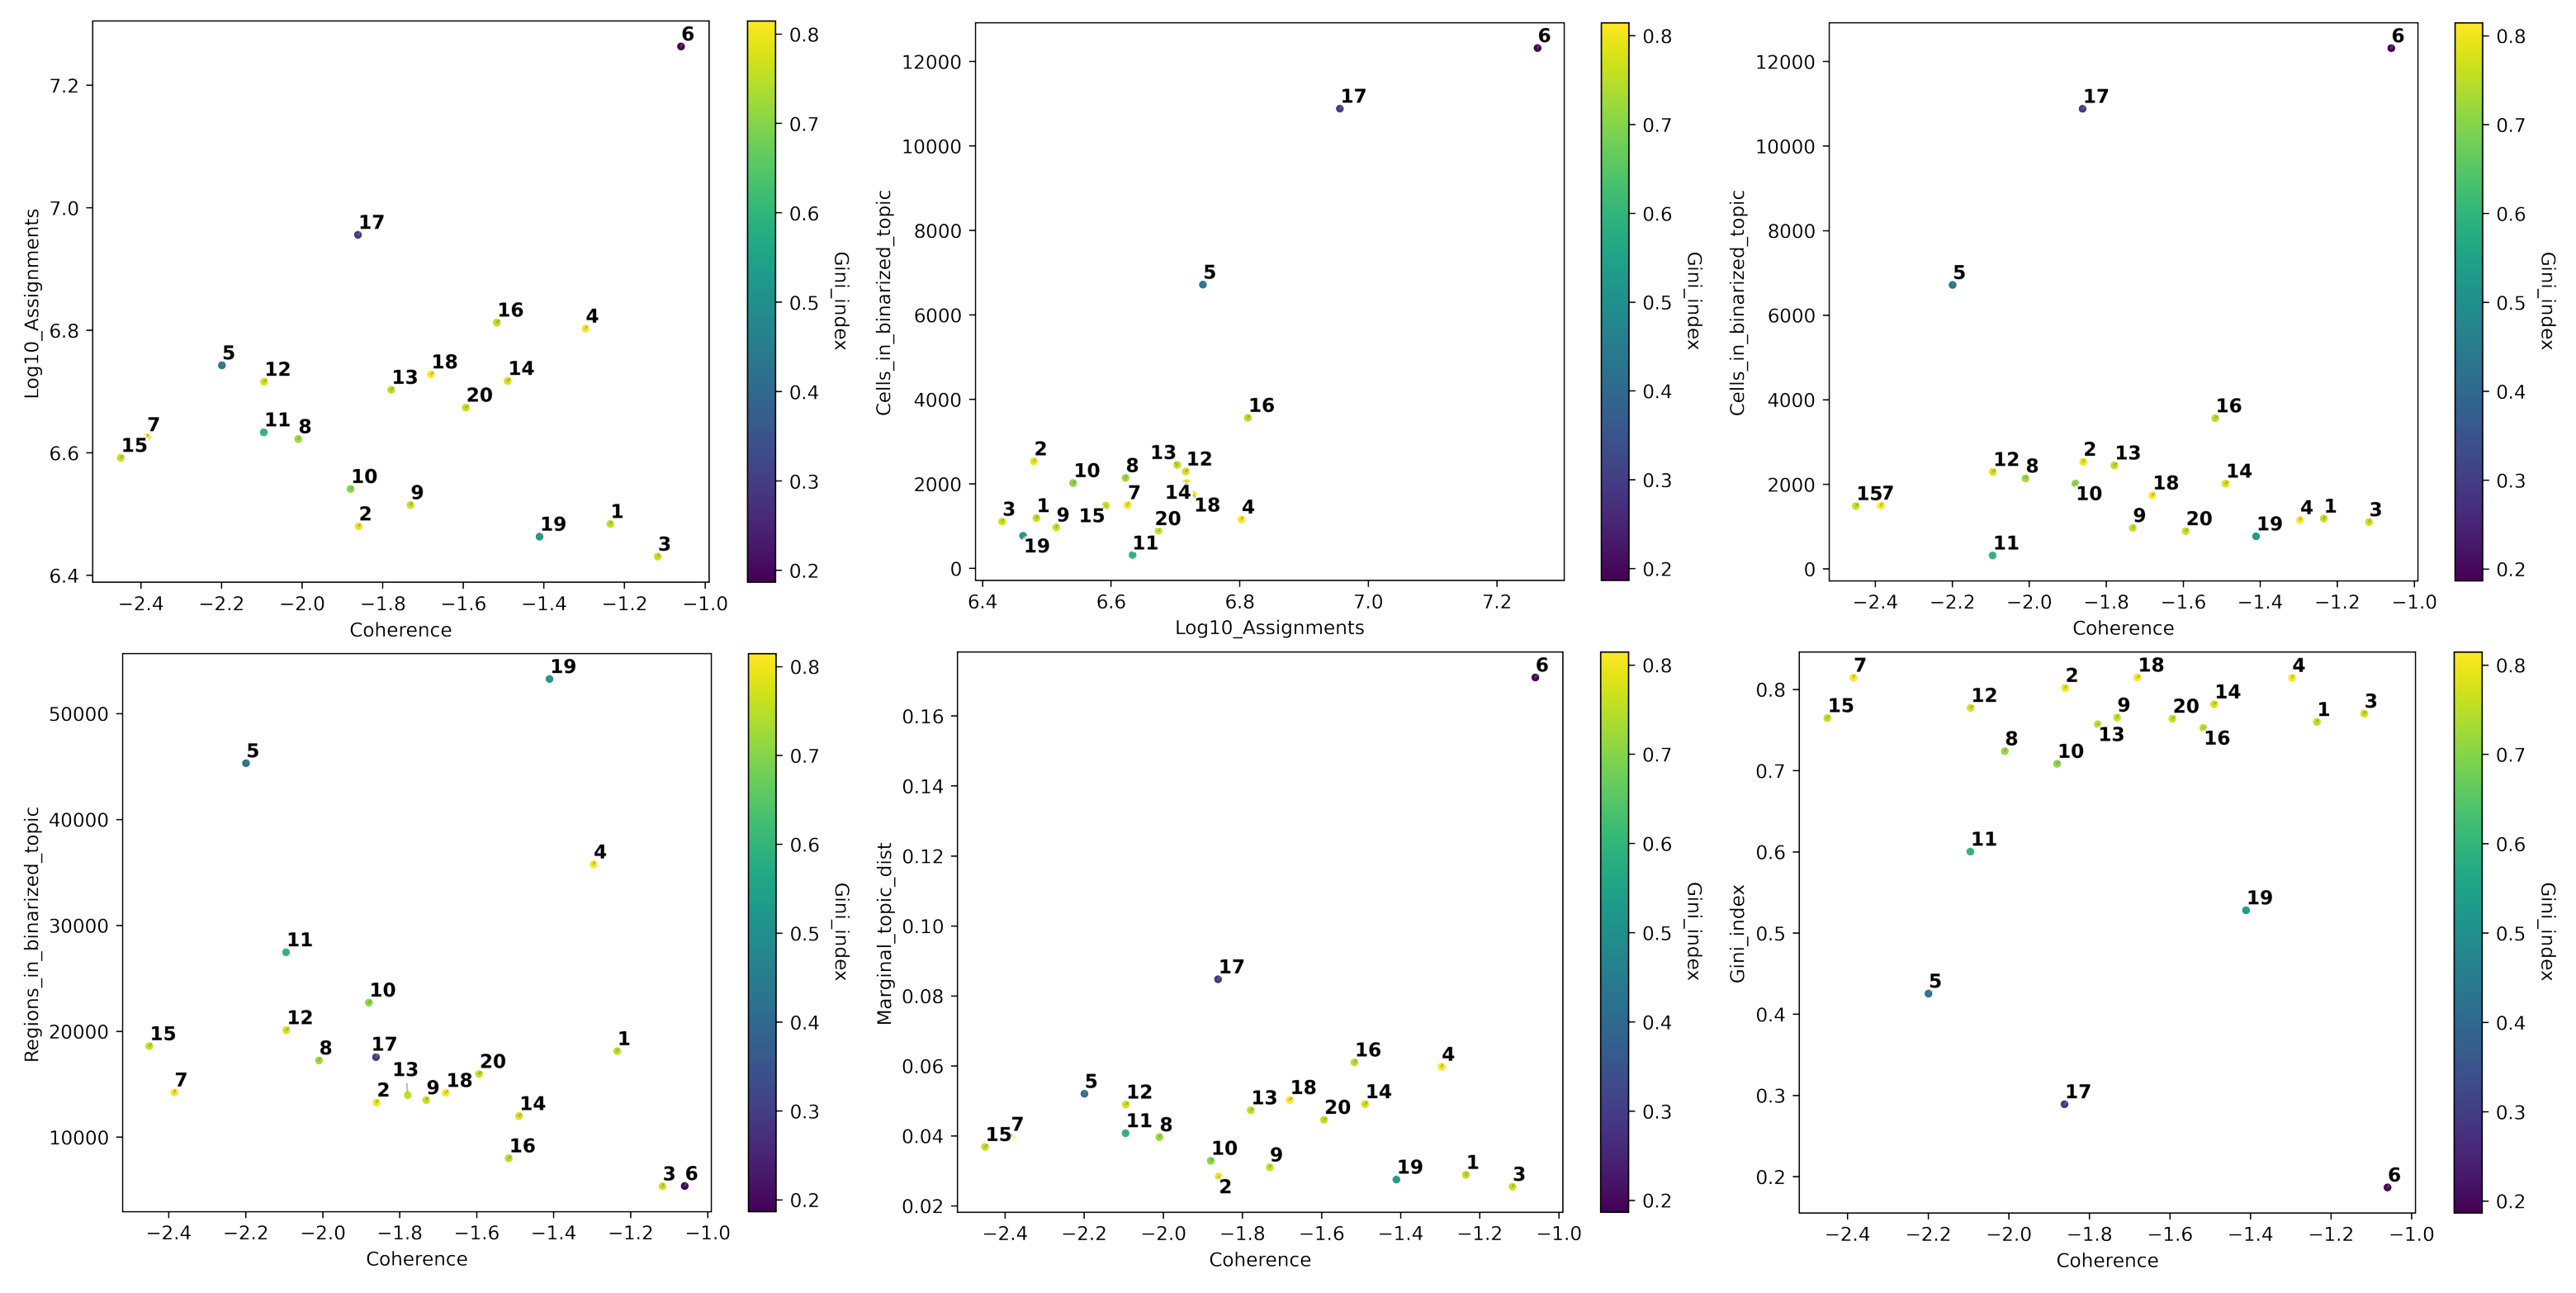

In [8]:
#pycistopic
os.mkdir(outDir + 'topic_binarization')
from pycisTopic.topic_binarization import *
region_bin_topics = binarize_topics(cistopic_obj, method = 'otsu', ntop = 3000, plot = True, num_columns = 5, save = outDir + 'topic_binarization/otsu.pdf')

binarized_cell_topic = binarize_topics(cistopic_obj, target = 'cell', method = 'li', plot = True, num_columns = 5, nbins = 60)

## compute QC metrics.
from pycisTopic.topic_qc import *
topic_qc_metrics = compute_topic_metrics(cistopic_obj)

fig_dict={}
fig_dict['CoherenceVSAssignments']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Log10_Assignments', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['AssignmentsVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Log10_Assignments', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSCells_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Cells_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSRegions_in_bin']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Regions_in_binarized_topic', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSMarginal_dist']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Marginal_topic_dist', var_color='Gini_index', plot=False, return_fig=True)
fig_dict['CoherenceVSGini_index']=plot_topic_qc(topic_qc_metrics, var_x='Coherence', var_y='Gini_index', var_color='Gini_index', plot=False, return_fig=True)

# Plot topic stats in one figure
fig=plt.figure(figsize=(40, 43))
i = 1
for fig_ in fig_dict.keys():
    plt.subplot(2, 3, i)
    img = fig2img(fig_dict[fig_]) #To convert figures to png to plot together, see .utils.py. This converts the figure to png.
    plt.imshow(img)
    plt.axis('off')
    i += 1
plt.subplots_adjust(wspace=0, hspace=-0.70)
fig.savefig(outDir + 'topic_binarization/Topic_qc.pdf', bbox_inches='tight')
plt.show()

topic_annot = topic_annotation(cistopic_obj, annot_var='lineage', binarized_cell_topic=binarized_cell_topic, general_topic_thr = 0.2)

# Save
with open(outDir + 'topic_binarization/Topic_qc_metrics_annot.pkl', 'wb') as f:
    pickle.dump(topic_qc_metrics, f)
with open(outDir + 'topic_binarization/binarized_cell_topic.pkl', 'wb') as f:
    pickle.dump(binarized_cell_topic, f)
with open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'wb') as f:
    pickle.dump(region_bin_topics, f)
    

In [11]:
#pycistarget DAR

2023-04-11 01:17:45,519 cisTopic     INFO     Imputing drop-outs
2023-04-11 01:18:55,757 cisTopic     INFO     Scaling
2023-04-11 01:19:39,000 cisTopic     INFO     Keep non zero rows
2023-04-11 01:20:24,930 cisTopic     INFO     Imputed accessibility sparsity: 0.7204695411826788
2023-04-11 01:20:24,933 cisTopic     INFO     Create CistopicImputedFeatures object
2023-04-11 01:20:24,934 cisTopic     INFO     Making matrix sparse
2023-04-11 01:24:11,246 cisTopic     INFO     Done!
2023-04-11 01:24:11,363 cisTopic     INFO     Normalizing imputed data
2023-04-11 01:28:01,846 cisTopic     INFO     Done!


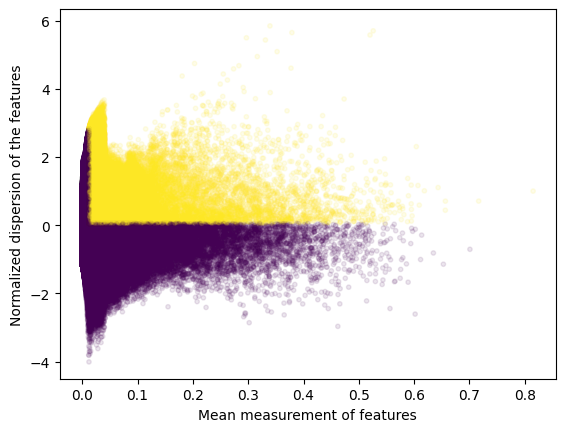

2023-04-11 01:30:56,787 cisTopic     INFO     Done!


In [4]:
from pycisTopic.diff_features import *
imputed_acc_obj = impute_accessibility(cistopic_obj, selected_cells=None, selected_regions=cistopic_obj.region_names, scale_factor=10**6)

normalized_imputed_acc_obj = normalize_scores(imputed_acc_obj, scale_factor=10**4)

os.mkdir(outDir+'DARs')
variable_regions = find_highly_variable_features(normalized_imputed_acc_obj,
                                           min_disp = 0.05,
                                           min_mean = 0.0125,
                                           max_mean = 3,
                                           max_disp = np.inf,
                                           n_bins=20,
                                           n_top_features=None,
                                           plot=True,
                                           save= outDir + 'DARs/HVR_plot.pdf')

In [5]:
markers_dict= find_diff_features(cistopic_obj,
                      imputed_acc_obj,
                      variable='lineage',
                      var_features=variable_regions,
                      contrasts=None,
                      adjpval_thr=0.05,
                      log2fc_thr=np.log2(1.5),
                      n_cpu=15,
                      _temp_dir=tmpDir + 'ray_spill',
                      split_pattern = '-',ignore_reinit_error=True)

x = [print(x + ': '+ str(len(markers_dict[x]))) for x in markers_dict.keys()]

2023-04-11 01:32:05,075	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


(markers_ray pid=5816) 2023-04-11 01:32:12,219 cisTopic     INFO     Formatting data for Endothelial
(markers_ray pid=5815) 2023-04-11 01:32:13,733 cisTopic     INFO     Formatting data for Epithelial
(markers_ray pid=6005) 2023-04-11 01:32:16,419 cisTopic     INFO     Formatting data for Gut
(markers_ray pid=6004) 2023-04-11 01:32:17,762 cisTopic     INFO     Formatting data for Hepatocyte
(markers_ray pid=6240) 2023-04-11 01:32:20,612 cisTopic     INFO     Formatting data for Immune
(markers_ray pid=6239) 2023-04-11 01:32:22,078 cisTopic     INFO     Formatting data for Muscle
(markers_ray pid=6448) 2023-04-11 01:32:25,282 cisTopic     INFO     Formatting data for Neural
(markers_ray pid=6447) 2023-04-11 01:32:27,540 cisTopic     INFO     Formatting data for Renal
(markers_ray pid=6659) 2023-04-11 01:32:30,947 cisTopic     INFO     Formatting data for Stromal
(markers_ray pid=5816) 2023-04-11 01:32:35,196 cisTopic     INFO     Computing p-value for Endothelial
(markers_ray pid=5815) 

In [ ]:
# Save
with open(outDir + 'DARs/Imputed_accessibility.pkl', 'wb') as f:
    pickle.dump(imputed_acc_obj, f)
with open(outDir + 'DARs/DARs.pkl', 'wb') as f:
    pickle.dump(markers_dict, f)


In [15]:
#pycistarget motif

In [3]:
import pickle
infile = open(outDir + 'topic_binarization/binarized_topic_region.pkl', 'rb')
binarized_topic_region = pickle.load(infile)
infile.close()

import pickle
infile = open(outDir + 'DARs/DARs.pkl', 'rb')
DARs_dict = pickle.load(infile)
infile.close()

In [4]:
DARs_dict 

{'Endothelial':                          Log2FC Adjusted_pval     Contrast
 9:9391686-9392186      6.334464           0.0  Endothelial
 6:159408797-159409297   6.32807           0.0  Endothelial
 19:41060789-41061289   6.307967           0.0  Endothelial
 2:21553941-21554441    6.296974           0.0  Endothelial
 4:137427910-137428410  6.296189           0.0  Endothelial
 ...                         ...           ...          ...
 11:17185690-17186190   0.585105           0.0  Endothelial
 9:65298049-65298549    0.585066           0.0  Endothelial
 11:57209268-57209768   0.585055           0.0  Endothelial
 18:18038099-18038599   0.585014           0.0  Endothelial
 1:136313809-136314309  0.584993           0.0  Endothelial
 
 [20495 rows x 3 columns],
 'Epithelial':                          Log2FC Adjusted_pval    Contrast
 7:159745525-159746025  6.207261           0.0  Epithelial
 10:91717376-91717876   6.189764           0.0  Epithelial
 12:13365247-13365747   6.189764           0.

In [5]:
# format region sets
import re
import pyranges as pr
from pycistarget.utils import *
region_sets = {}
#region_sets['Topics'] = {key : pr.PyRanges(region_names_to_coordinates(binarized_topic_region[key].index.tolist())) for key in binarized_topic_region.keys()}
region_sets['DARs'] = {re.sub('[^A-Za-z0-9]+', '_', key): pr.PyRanges(region_names_to_coordinates(DARs_dict[key].index.tolist())) for key in DARs_dict.keys()}

# Run pycistarget
# run_without_promoters = True, will run the methods in all regions + the region sets without promoters
savepath = outDir + 'pycisTarget/'
if not os.path.exists(savepath):
    os.mkdir(savepath)

import os
from scenicplus.wrappers.run_pycistarget import *

In [6]:
run_pycistarget(region_sets,
                 ctx_db_path = '/media/ggj/Guo-4T-AI/Scenicplus_database/macaca.regions_vs_motifs.rankings.feather',
                 species = 'mfascicularis',
                 save_path = savepath,
                 run_without_promoters = False,
                 biomart_host = 'http://www.ensembl.org',
                 promoter_space = 500,
                 ctx_auc_threshold = 0.005,
                 ctx_nes_threshold = 3.0,
                 ctx_rank_threshold = 0.05,
                 dem_log2fc_thr = 0.5,
                 dem_motif_hit_thr = 3.0,
                 dem_max_bg_regions = 500,
                 n_cpu = 16,
                 _temp_dir = tmpDir,
               ignore_reinit_error=True,
               path_to_motif_annotations = '/media/ggj/Guo-4T-AI/Scenicplus_database/macaca_motif2tf_orthologuous.tbl',
              # annotation_version = 'v10nr_clust',
               annotation = ['Direct_annot', 'Orthology_annot'])

2023-04-11 01:57:52,186 pycisTarget_wrapper INFO     /media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/output/pycisTarget/ folder already exists.
2023-04-11 01:57:52,524 pycisTarget_wrapper INFO     Loading cisTarget database for DARs
2023-04-11 01:57:52,525 cisTarget    INFO     Reading cisTarget database
2023-04-11 01:58:59,356 pycisTarget_wrapper INFO     Running cisTarget for DARs
(ctx_internal_ray pid=10046) 2023-04-11 01:59:01,773 cisTarget    INFO     Running cisTarget for Endothelial which has 17703 regions
(ctx_internal_ray pid=10045) 2023-04-11 01:59:02,222 cisTarget    INFO     Running cisTarget for Epithelial which has 19068 regions
(ctx_internal_ray pid=10238) 2023-04-11 01:59:03,333 cisTarget    INFO     Running cisTarget for Gut which has 19470 regions
(ctx_internal_ray pid=10237) 2023-04-11 01:59:03,763 cisTarget    INFO     Running cisTarget for Hepatocyte which has 18809 regions
(ctx_internal_ray pid=10406) 2023-04-11 01:59:05,146 cisTarget    INFO     Running cisTarg